# **MRMS/CCRFCD** rain-gauge data analysis
---

- Time Period: [2021.01.01-2025.07.25]
- **`TODO`**: describe data-collection methodology in detail
- **`TODO`**: explain format of master-dataframe
- **`TODO`**: upload compressed master-df
- **`TODO`**: test notebook in Google Colab

### 0. Packages, imports, and magic constants

In [45]:
# !pip install numpy pandas matplotlib scikit-learn -q
# unzip mrms/ccrfcd aligned data `.csv` file
!gzip -d "./data/events/2021-01-01_2025-07-25_all_events.csv" -k

gzip: ./data/events/2021-01-01_2025-07-25_all_events.csv: unknown suffix -- ignored


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from datetime import datetime


ALL_EVENTS_DF = "./data/events/2021-01-01_2025-07-25_all_events.csv"

### 1. Exploring the dataset

We have already built a tabular dataset of MRMS and CCRFCD rain gauge 1H QPE values for days between 01-01-21 and 07-25-25 during which a **meaningful amount** of rain fell in the Las Vegas valley area. Below, we load raw data from memory into a `pandas.DataFrame` object.

> More details can be found in the `readme.md` in this repo.

In [47]:
df = pd.read_csv(ALL_EVENTS_DF)

# filter out extreme values (i.e., <= 0.001 and >= 0.999 percentile)
# occasional outlier rain-gauge values appear in the CCRFCD database; CCRFCD does not perform any QC
mask = (df["delta_qpe"] > df["delta_qpe"].quantile(0.001)) & (
    df["delta_qpe"] < df["delta_qpe"].quantile(0.999)
)
df = df.loc[mask]

# drop some unused columns
df = df.drop(["cum_gauge_qpe", "cum_mrms_qpe"], axis=1)

# convert start/end times to datetime objs
df["start_time"] = pd.to_datetime(df["start_time"])
df["event_time"] = pd.to_datetime(df["end_time"])

df.head()

,start_time,end_time,station_id,lat,lon,gauge_qpe,mrms_qpe,delta_qpe,event_time
0,2021-01-23 23:00:00,2021-01-24 00:00:00,4709,35.925000,244.883000,0.00,0.003937,-0.003937,2021-01-24
1,2021-01-23 23:00:00,2021-01-24 00:00:00,4564,36.028250,244.996361,0.04,0.000000,0.040000,2021-01-24
2,2021-01-23 23:00:00,2021-01-24 00:00:00,4779,36.021861,245.041250,0.04,0.000000,0.040000,2021-01-24
3,2021-01-23 23:00:00,2021-01-24 00:00:00,4984,35.729250,244.811972,0.00,0.011811,-0.011811,2021-01-24
4,2021-01-23 23:00:00,2021-01-24 00:00:00,4724,35.939417,244.922250,0.00,0.015748,-0.015748,2021-01-24


Let's break down each of these columns:
- `start_time`: (**UTC**)
- `end_time`: (**UTC**)
- `station_id`: the CCRFCD rain-gauge's ID number
- `lat`/`lon`: location of the rain-gauge
- `gauge_qpe`: **(inches)** cummulative rainfall recorded by gauge between `start_time`/`end_time`
- `mrms_qpe`: **(inches)** cummulative rainfall recorded by MRMS radar-only product between `start_time`/`end_time` at `lat`/`lon`
    - Value for *the **nearest** MRMS grid-cell* to `lat`/`lon`
- `delta_qpe`: `gauge_qpe` - `mrms_qpe`

In [48]:
print(f"# Data points: {len(df)}")
print(f"# Unique gauges: {len(set(df['station_id']))}")

# Data points: 2337407
# Unique gauges: 223


#### 1.1. Distribution of unique datetimes

In [49]:
# t: unique timesteps in set of all timesteps {1, ..., n}
unique_dts = {s for s in set(df['start_time'])}
print(f"# Unique timesteps: {len(unique_dts)}")

# Unique timesteps: 82376


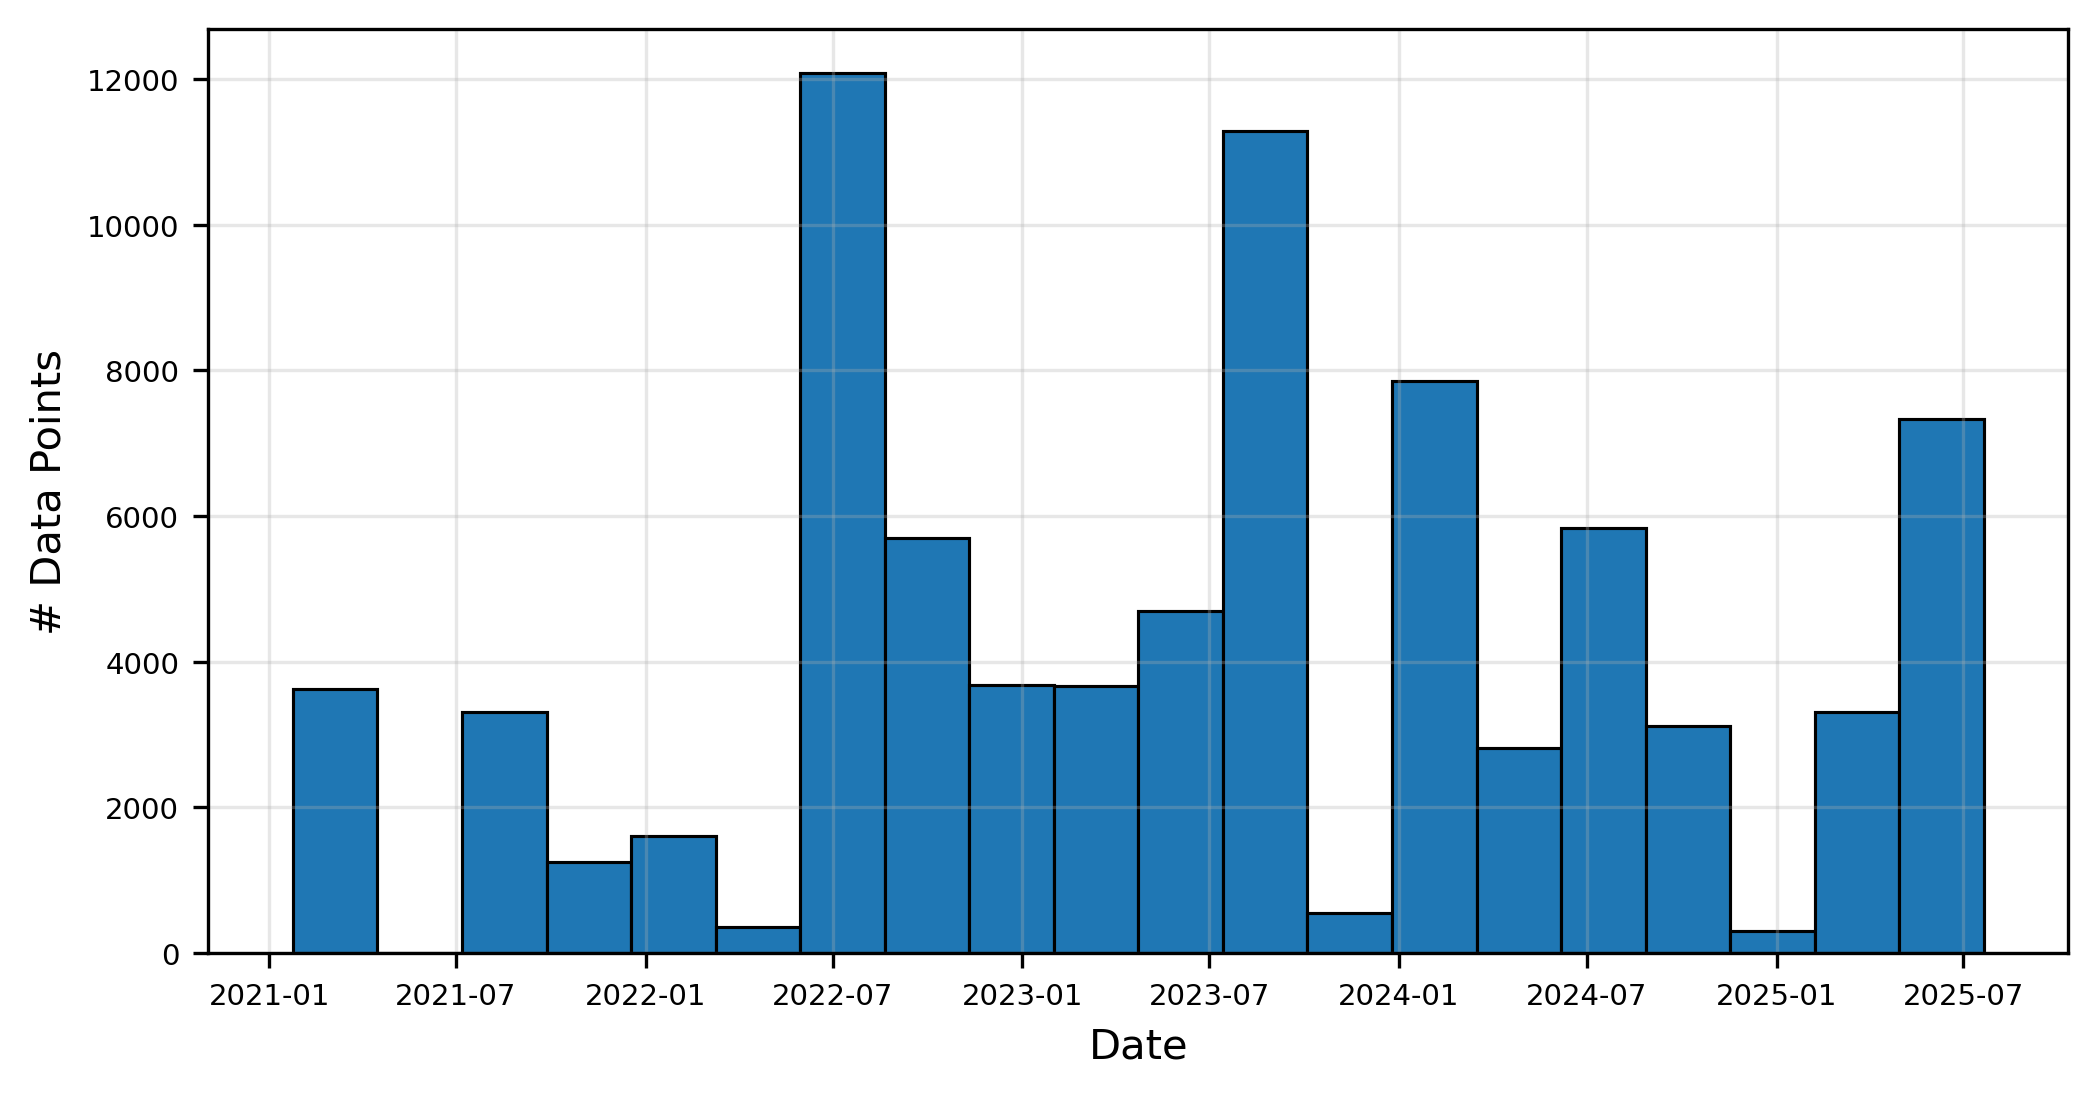

In [50]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

ax.hist(unique_dts, edgecolor='black', linewidth=0.75, bins=20)
ax.grid(alpha=0.3)

plt.xlabel("Date")
plt.xticks(fontsize=7)
plt.ylabel("# Data Points")
plt.yticks(fontsize=7)
plt.show()

#### 1.2. Distribution of total `mrms_qpe` by month

- Below we sum all the MRMS 1H-QPE values at each rain gauge.

In [51]:
months = df["start_time"].dt.month
years  = df['start_time'].dt.year

all_values = []
for i in range(1, 13):
    month_arr = []
    for j in range(2021, 2025 + 1):
        mask       = months.between(i, i) & years.between(j, j)
        delta_qpes = df.loc[mask, "mrms_qpe"].tolist()
        total_qpe  = float(np.array(delta_qpes).sum())
        if total_qpe > 0.0:
            month_arr.append(total_qpe)
    all_values.append(month_arr)

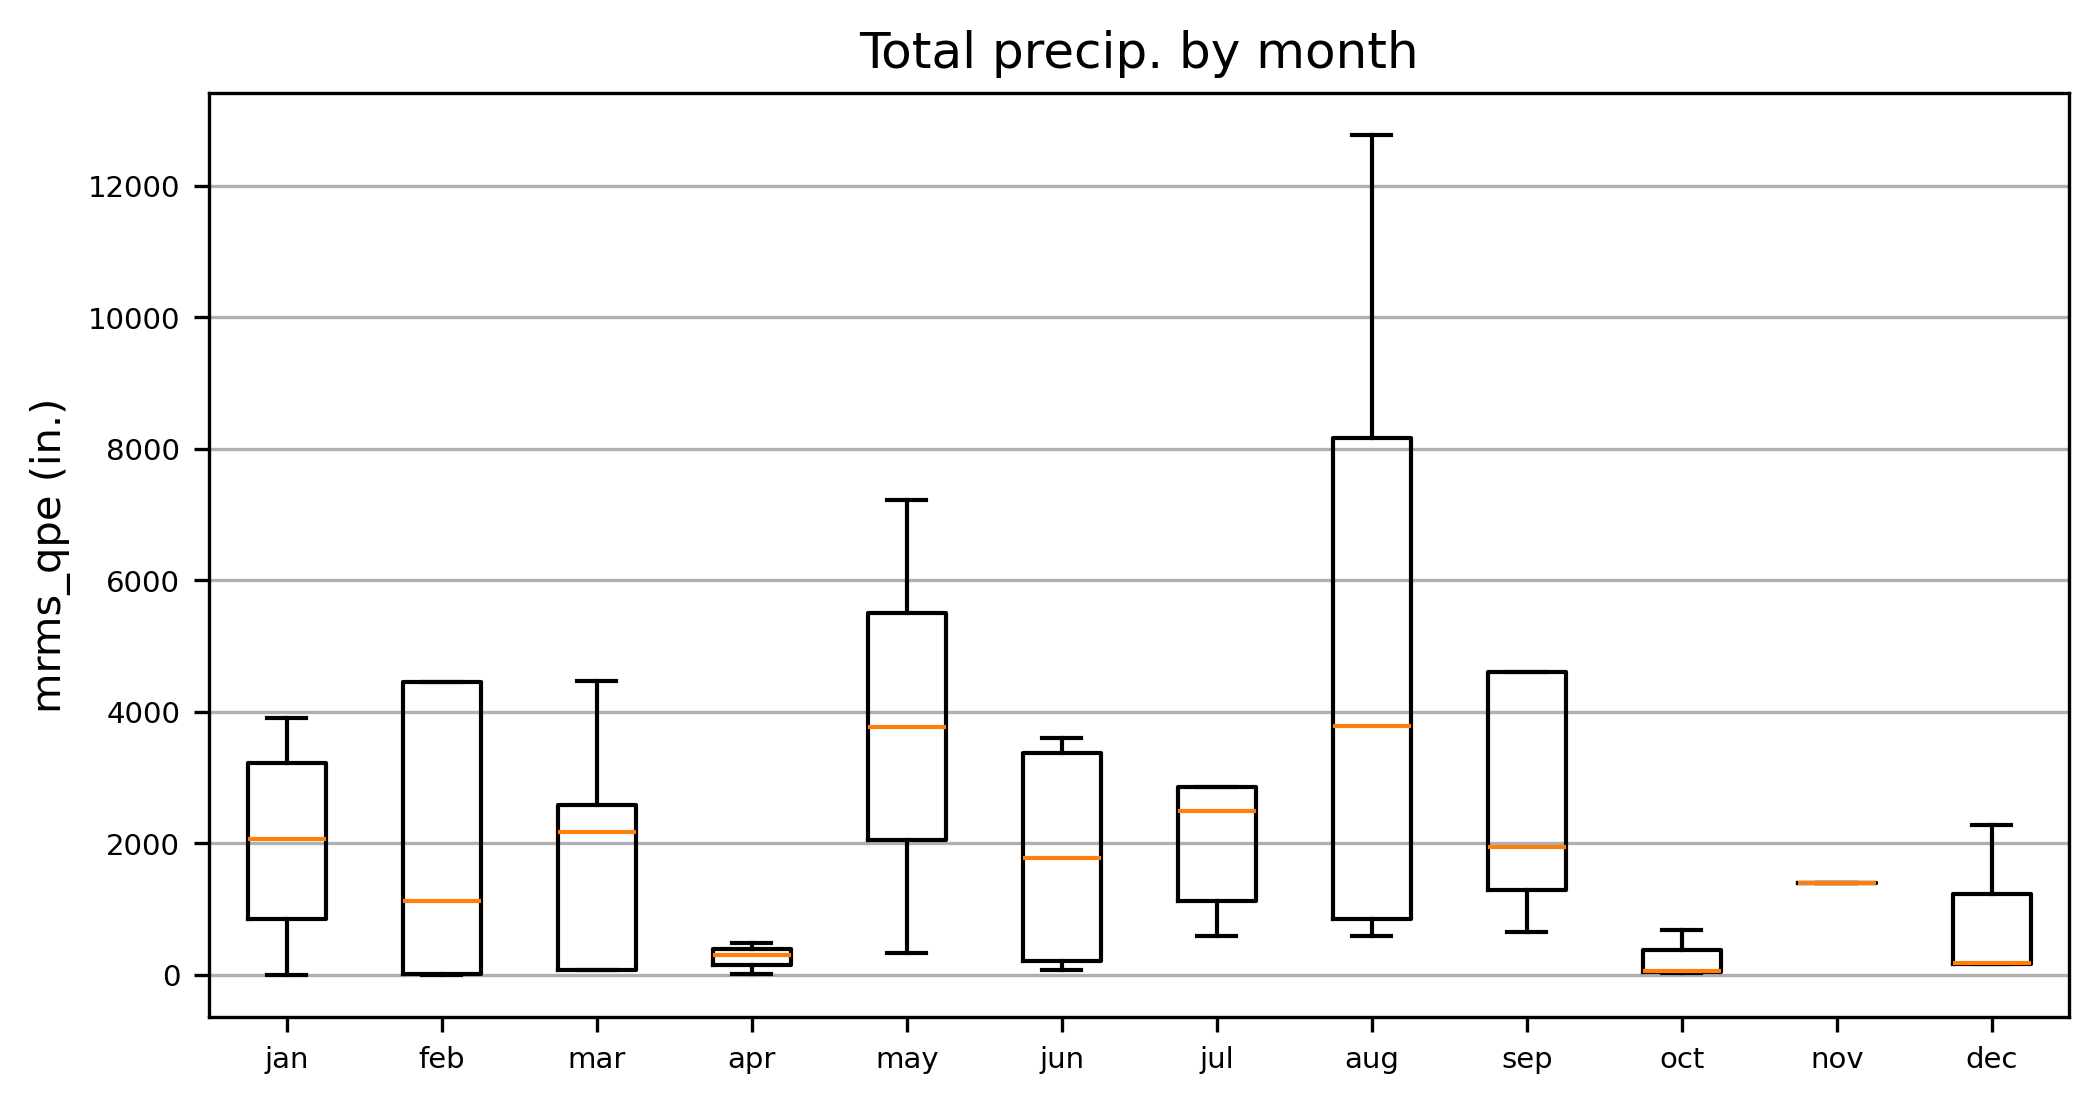

In [52]:
fig, axs = plt.subplots(figsize=(8, 4), dpi=300)
axs.boxplot(
    all_values,
    notch=False,
    showfliers=False,
    )

axs.yaxis.grid(True)
axs.set_xticks([y + 1 for y in range(12)],
                  labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])

plt.title("Total precip. by month")
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.ylabel("mrms_qpe (in.)")
plt.show()

### 2. Per-Event Analysis

#### 2.1. Constructing Synthetic Rainfall "Events"

- Currently, our dataset lacks any meaningful markers to segment moments in time into distinct rainfall "events". Below, we create synthetic "events" to analyize temporal effects on rain gauge bias.

In [53]:
# sum of all MRMS values for all gauges at each unique timestep
grouped_df   = df[['start_time', 'mrms_qpe']].groupby('start_time').sum().copy()
cum_mrms_qpe = grouped_df['mrms_qpe']
series       = np.asarray(list(cum_mrms_qpe))

# lower bound of total precip at a timestep
# we denote this to be a "dry" period
p50          = np.percentile(series, 50)
print(f"50th percentile MRMS 1H-QPE: {p50:0.4f} in.")

50th percentile MRMS 1H-QPE: 0.1457 in.


In [54]:
def segment_rainfall_events(
        precip_array: np.ndarray, 
        interval_minutes=2, 
        wet_period_mins=15, 
        dry_period_mins=15,
        rain_threshold=p50,
    ) -> pd.DataFrame:
    """
    Segment a 1D array of total precip. values into 
        distinct events (i.e., [`start_time`, `end_time`]).

    Params
    - `wet_period_mins`
        - Number of minutes that must elapse where (rain_falling > rain_threshold) in order to begin a rainfall event
    - `dry_period_mins`
        - Number of minutes that must elapse where (rain_falling < rain_threshold) to label a period of time as "dry"

    Returns:
    ---
        pd.DataFrame: Columns include 'precipitation' and 'is_event' (bool).
    """

    # mask: rain is falling
    precip_series      = pd.Series(precip_array)
    is_rain: pd.Series = (precip_series > rain_threshold).astype(int)

    # our data is recorded with 2 minute timesteps
    # here, calculate the number of steps-per-interval
    wet_period_intervals = wet_period_mins // interval_minutes
    dry_period_intervals = dry_period_mins // interval_minutes
    
    rolling_wet     = is_rain.rolling(window=wet_period_intervals, min_periods=wet_period_intervals).sum()
    valid_wet_start = (rolling_wet == wet_period_intervals)
    rolling_dry     = is_rain.rolling(window=dry_period_intervals, min_periods=dry_period_intervals).sum()
    valid_dry_end   = (rolling_dry == 0)

    is_event = np.zeros_like(is_rain, dtype=bool)

    in_event = False
    start_idx = 0

    for i in range(len(is_rain)):
        if not in_event:

            # wait until a valid wet period starts
            if valid_wet_start.iloc[i]:
                in_event = True
                
                # start of rain
                start_idx = i - wet_period_intervals + 1 
        else:
            
            # if inside an event, check for a valid dry period to end the event
            if valid_dry_end.iloc[i]:
                end_idx = i - dry_period_intervals + 1
                is_event[start_idx:end_idx] = True
                in_event = False

    if in_event:
        is_event[start_idx:] = True

    return pd.DataFrame({
        'precipitation': precip_series,
        'is_event': is_event
    })

In [55]:
# segment total precip array into "events"
rainfall_events = segment_rainfall_events(series)

event_ids = []
curr_id   = -1
in_event  = False

for is_event in rainfall_events['is_event'].values:
    if is_event:
        if not in_event:
            curr_id += 1
            in_event = True
        event_ids.append(curr_id)
    else:
        in_event = False
        event_ids.append(np.nan)

grouped_df['event_id'] = event_ids
event_ids_mapped       = dict(zip(grouped_df.index, grouped_df['event_id'].values))

In [56]:
event_ids      = [event_ids_mapped[k] for k in list(df['start_time'])]
df['event_id'] = event_ids
df_rain_events = df.loc[df['event_id'] > 0.0]

print(f"# Data points for rain events: {len(df_rain_events)}")
print(f"# Unique events: {len(set(df_rain_events['event_id']))}")

# ~2.2M data points from rainfall "events"
df_rain_events.head()

# Data points for rain events: 2210621
# Unique events: 297


,start_time,end_time,station_id,lat,lon,gauge_qpe,mrms_qpe,delta_qpe,event_time,event_id
1666,2021-01-24 02:36:00,2021-01-24 03:36:00,4914,35.850389,244.552694,0.0,0.003937,-0.003937,2021-01-24 03:36:00,1.0
1667,2021-01-24 02:36:00,2021-01-24 03:36:00,4034,36.343167,244.833333,0.0,0.007874,-0.007874,2021-01-24 03:36:00,1.0
1668,2021-01-24 02:36:00,2021-01-24 03:36:00,4609,35.997778,244.714444,0.0,0.003937,-0.003937,2021-01-24 03:36:00,1.0
1669,2021-01-24 02:36:00,2021-01-24 03:36:00,4334,36.058000,244.677639,0.0,0.007874,-0.007874,2021-01-24 03:36:00,1.0
1670,2021-01-24 02:36:00,2021-01-24 03:36:00,8,35.961000,245.372360,0.0,0.027559,-0.027559,2021-01-24 03:36:00,1.0


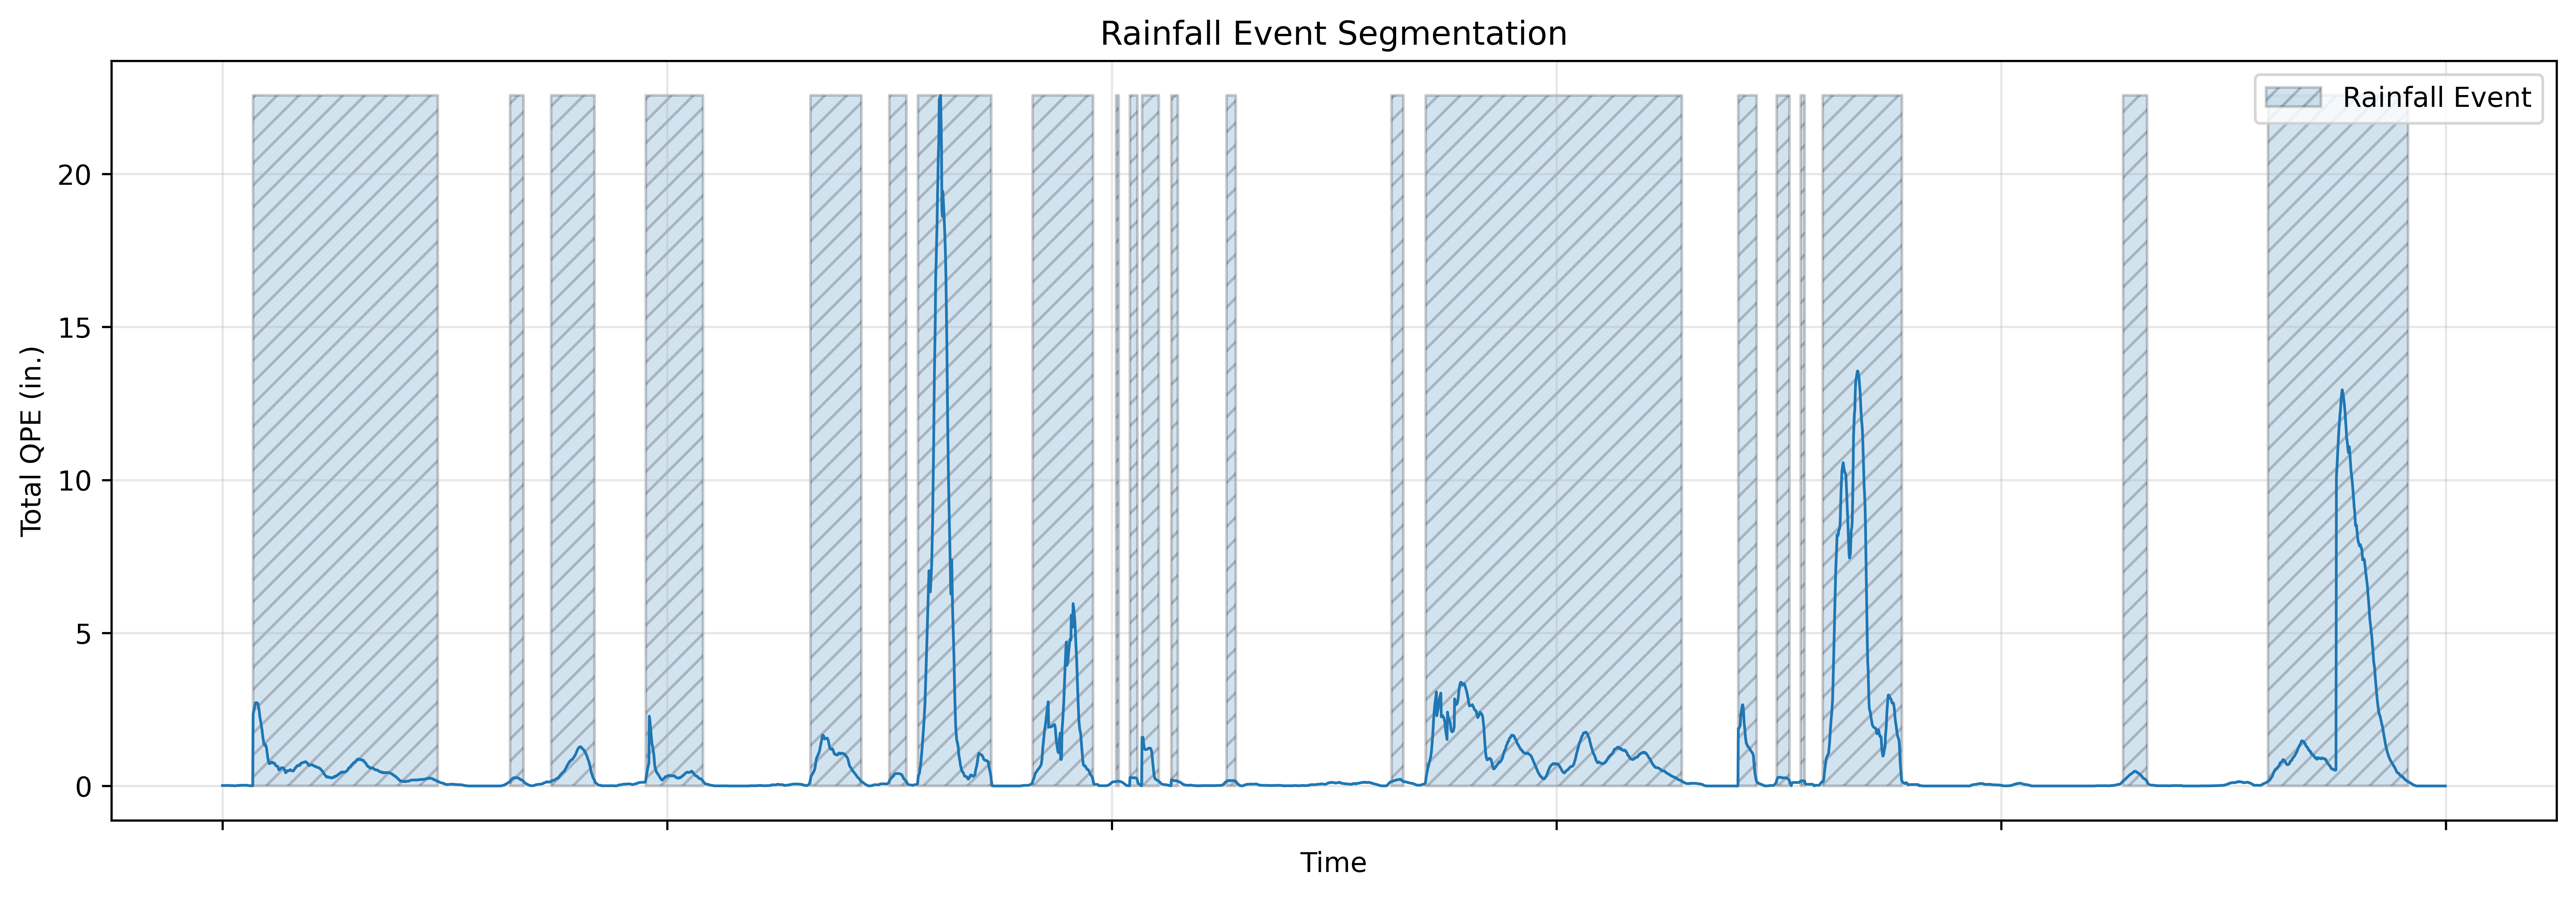

In [57]:
rainfall_events_subset = rainfall_events[3000:8000]

fig, ax = plt.subplots(figsize=(16, 5), dpi=600)

x = np.arange(0, len(rainfall_events_subset))
y = rainfall_events_subset['precipitation']

ax.fill_between(
    x, 
    0, 
    y.max(), 
    where=rainfall_events_subset['is_event'] > 0.0, 
    hatch='///',
    label="Rainfall Event",
    edgecolor="black",
    alpha=0.2,
    )
ax.plot(x, y, linewidth=1.0, scaley=True)

ax.set_ylabel("Total QPE (in.)")
ax.set_xlabel("Time")
ax.set_xticklabels([])
ax.grid(alpha=0.3)
ax.legend(loc="upper right")

plt.title("Rainfall Event Segmentation")
plt.show()

#### 2.2. Rain-Event Statistics

In [58]:
# create a list of `start_time` for each unique rain event
unique_events = df_rain_events.drop_duplicates(subset="event_id")
dts           = pd.to_datetime(unique_events["start_time"]).tolist()

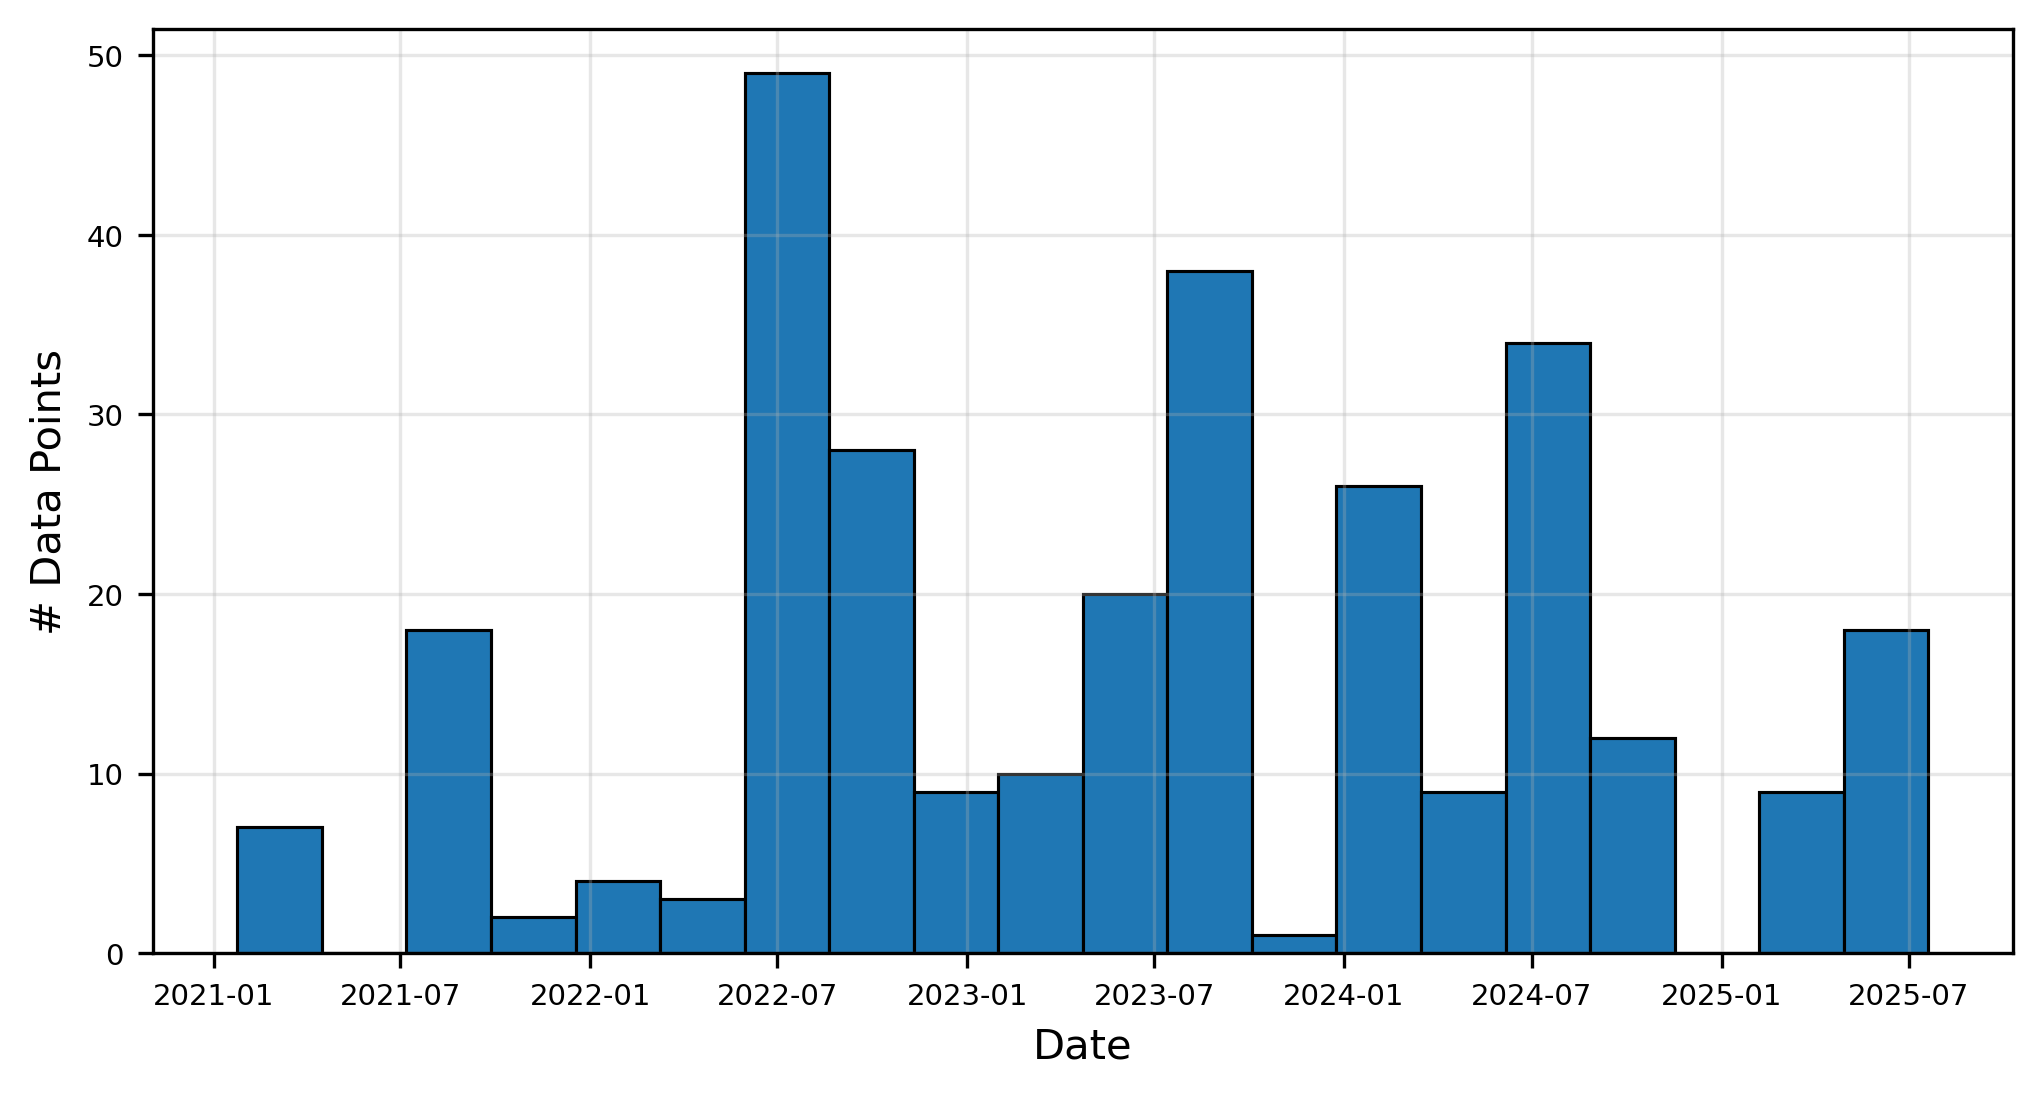

In [59]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

ax.hist(dts, edgecolor='black', linewidth=0.75, bins=20)
ax.grid(alpha=0.3)

plt.xlabel("Date")
plt.xticks(fontsize=7)
plt.ylabel("# Data Points")
plt.yticks(fontsize=7)
plt.show()

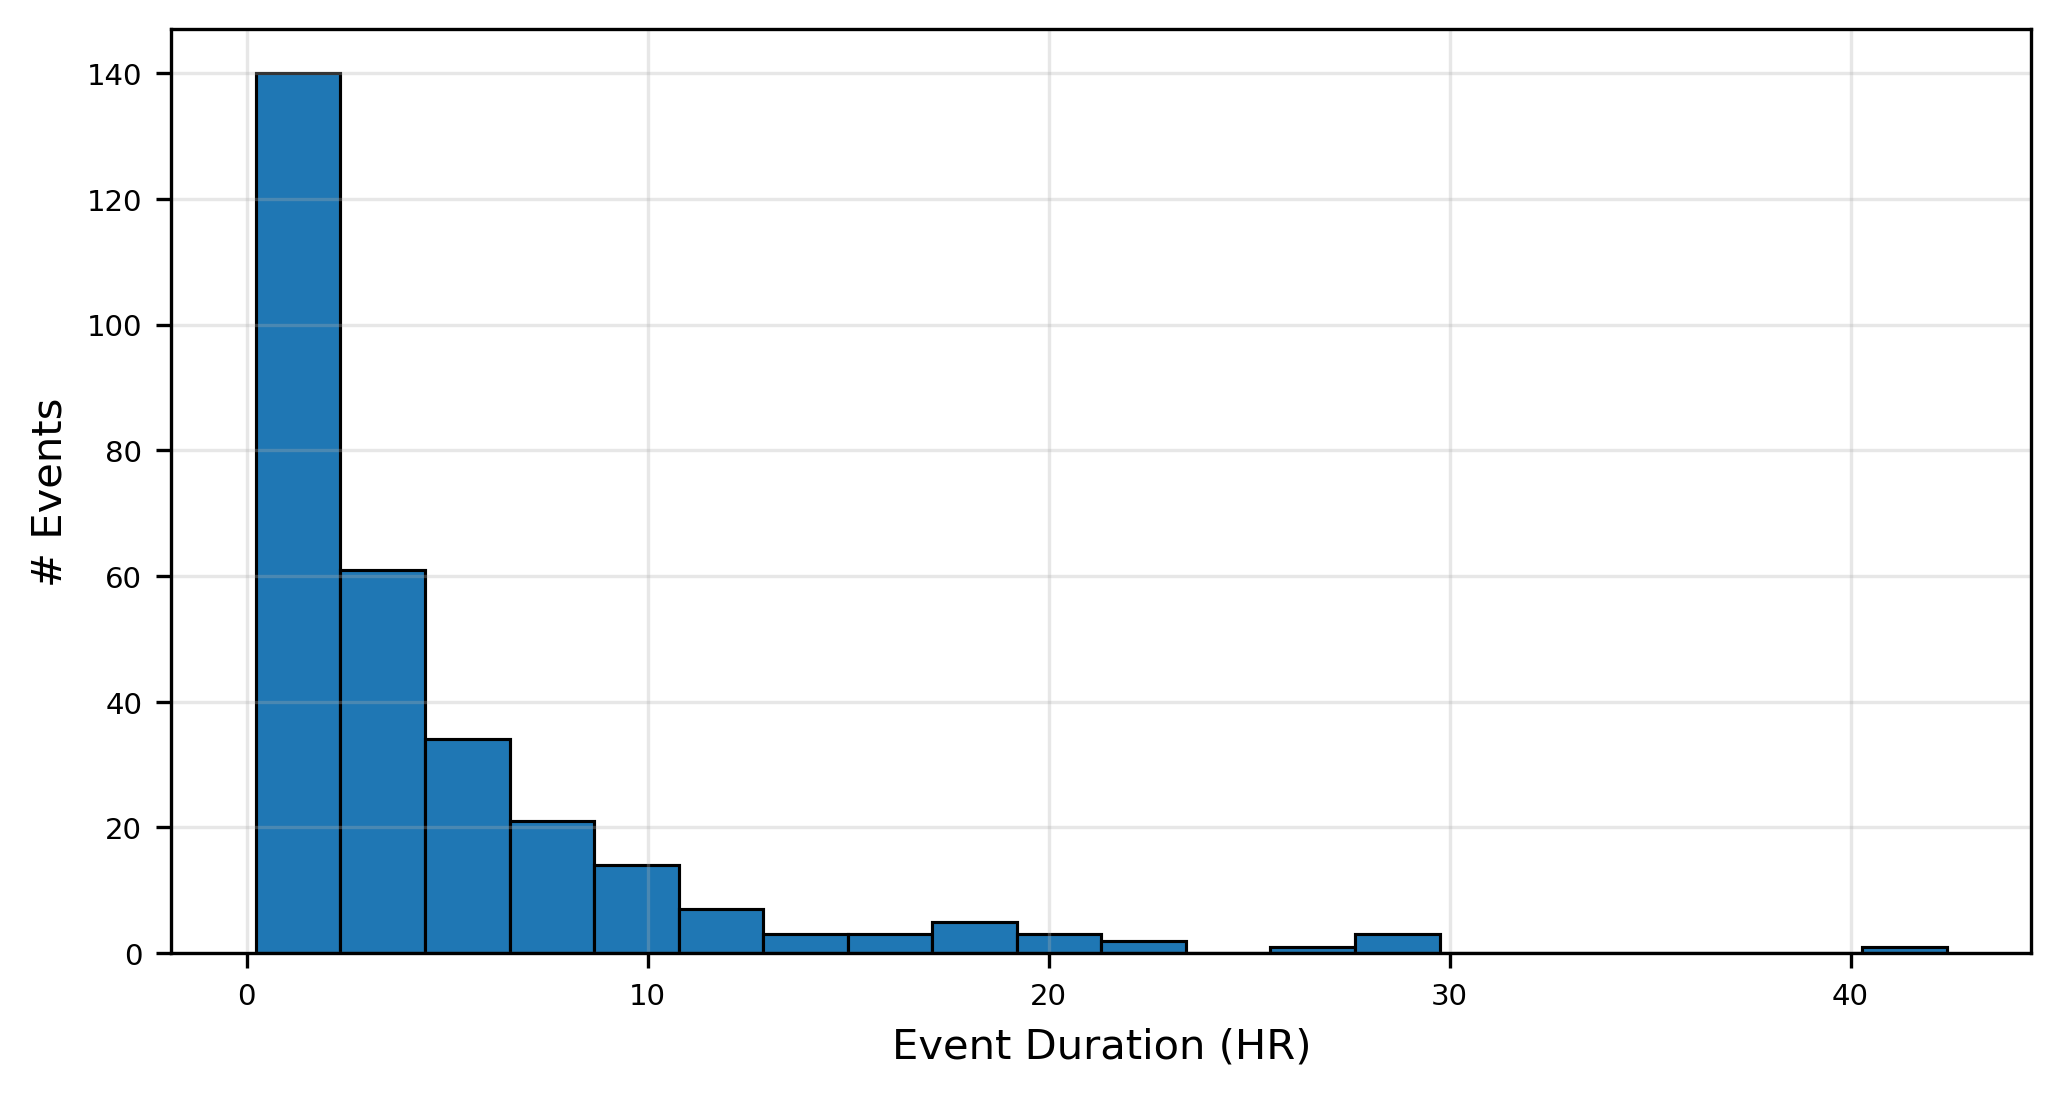

In [60]:
# a bit of a hack to grab the duration of each event
durations = grouped_df.groupby('event_id').count()['mrms_qpe']

# 2 min. buckets -> hrs
hr_durations = durations * (1/30)

fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

ax.hist(hr_durations, edgecolor='black', linewidth=0.75, bins=20)
ax.grid(alpha=0.3)

plt.xlabel("Event Duration (HR)")
plt.xticks(fontsize=7)
plt.ylabel("# Events")
plt.yticks(fontsize=7)
plt.show()

In [61]:
cols = ['start_time', 'event_id', 'mrms_qpe', 'gauge_qpe']
df   = df_rain_events[cols]
df   = (
    df.groupby(['event_id', 'start_time'], as_index=False)
      .sum(numeric_only=True)
      .sort_values(['event_id', 'start_time'])
)

df['t_idx'] = df.groupby('event_id').cumcount()

mrms_mat   = df.pivot(index='event_id', columns='t_idx', values='mrms_qpe')
gauge_mat  = df.pivot(index='event_id', columns='t_idx', values='gauge_qpe')

mrms_means   = np.nanmean(mrms_mat.to_numpy(),  axis=0)
gauge_means  = np.nanmean(gauge_mat.to_numpy(), axis=0)

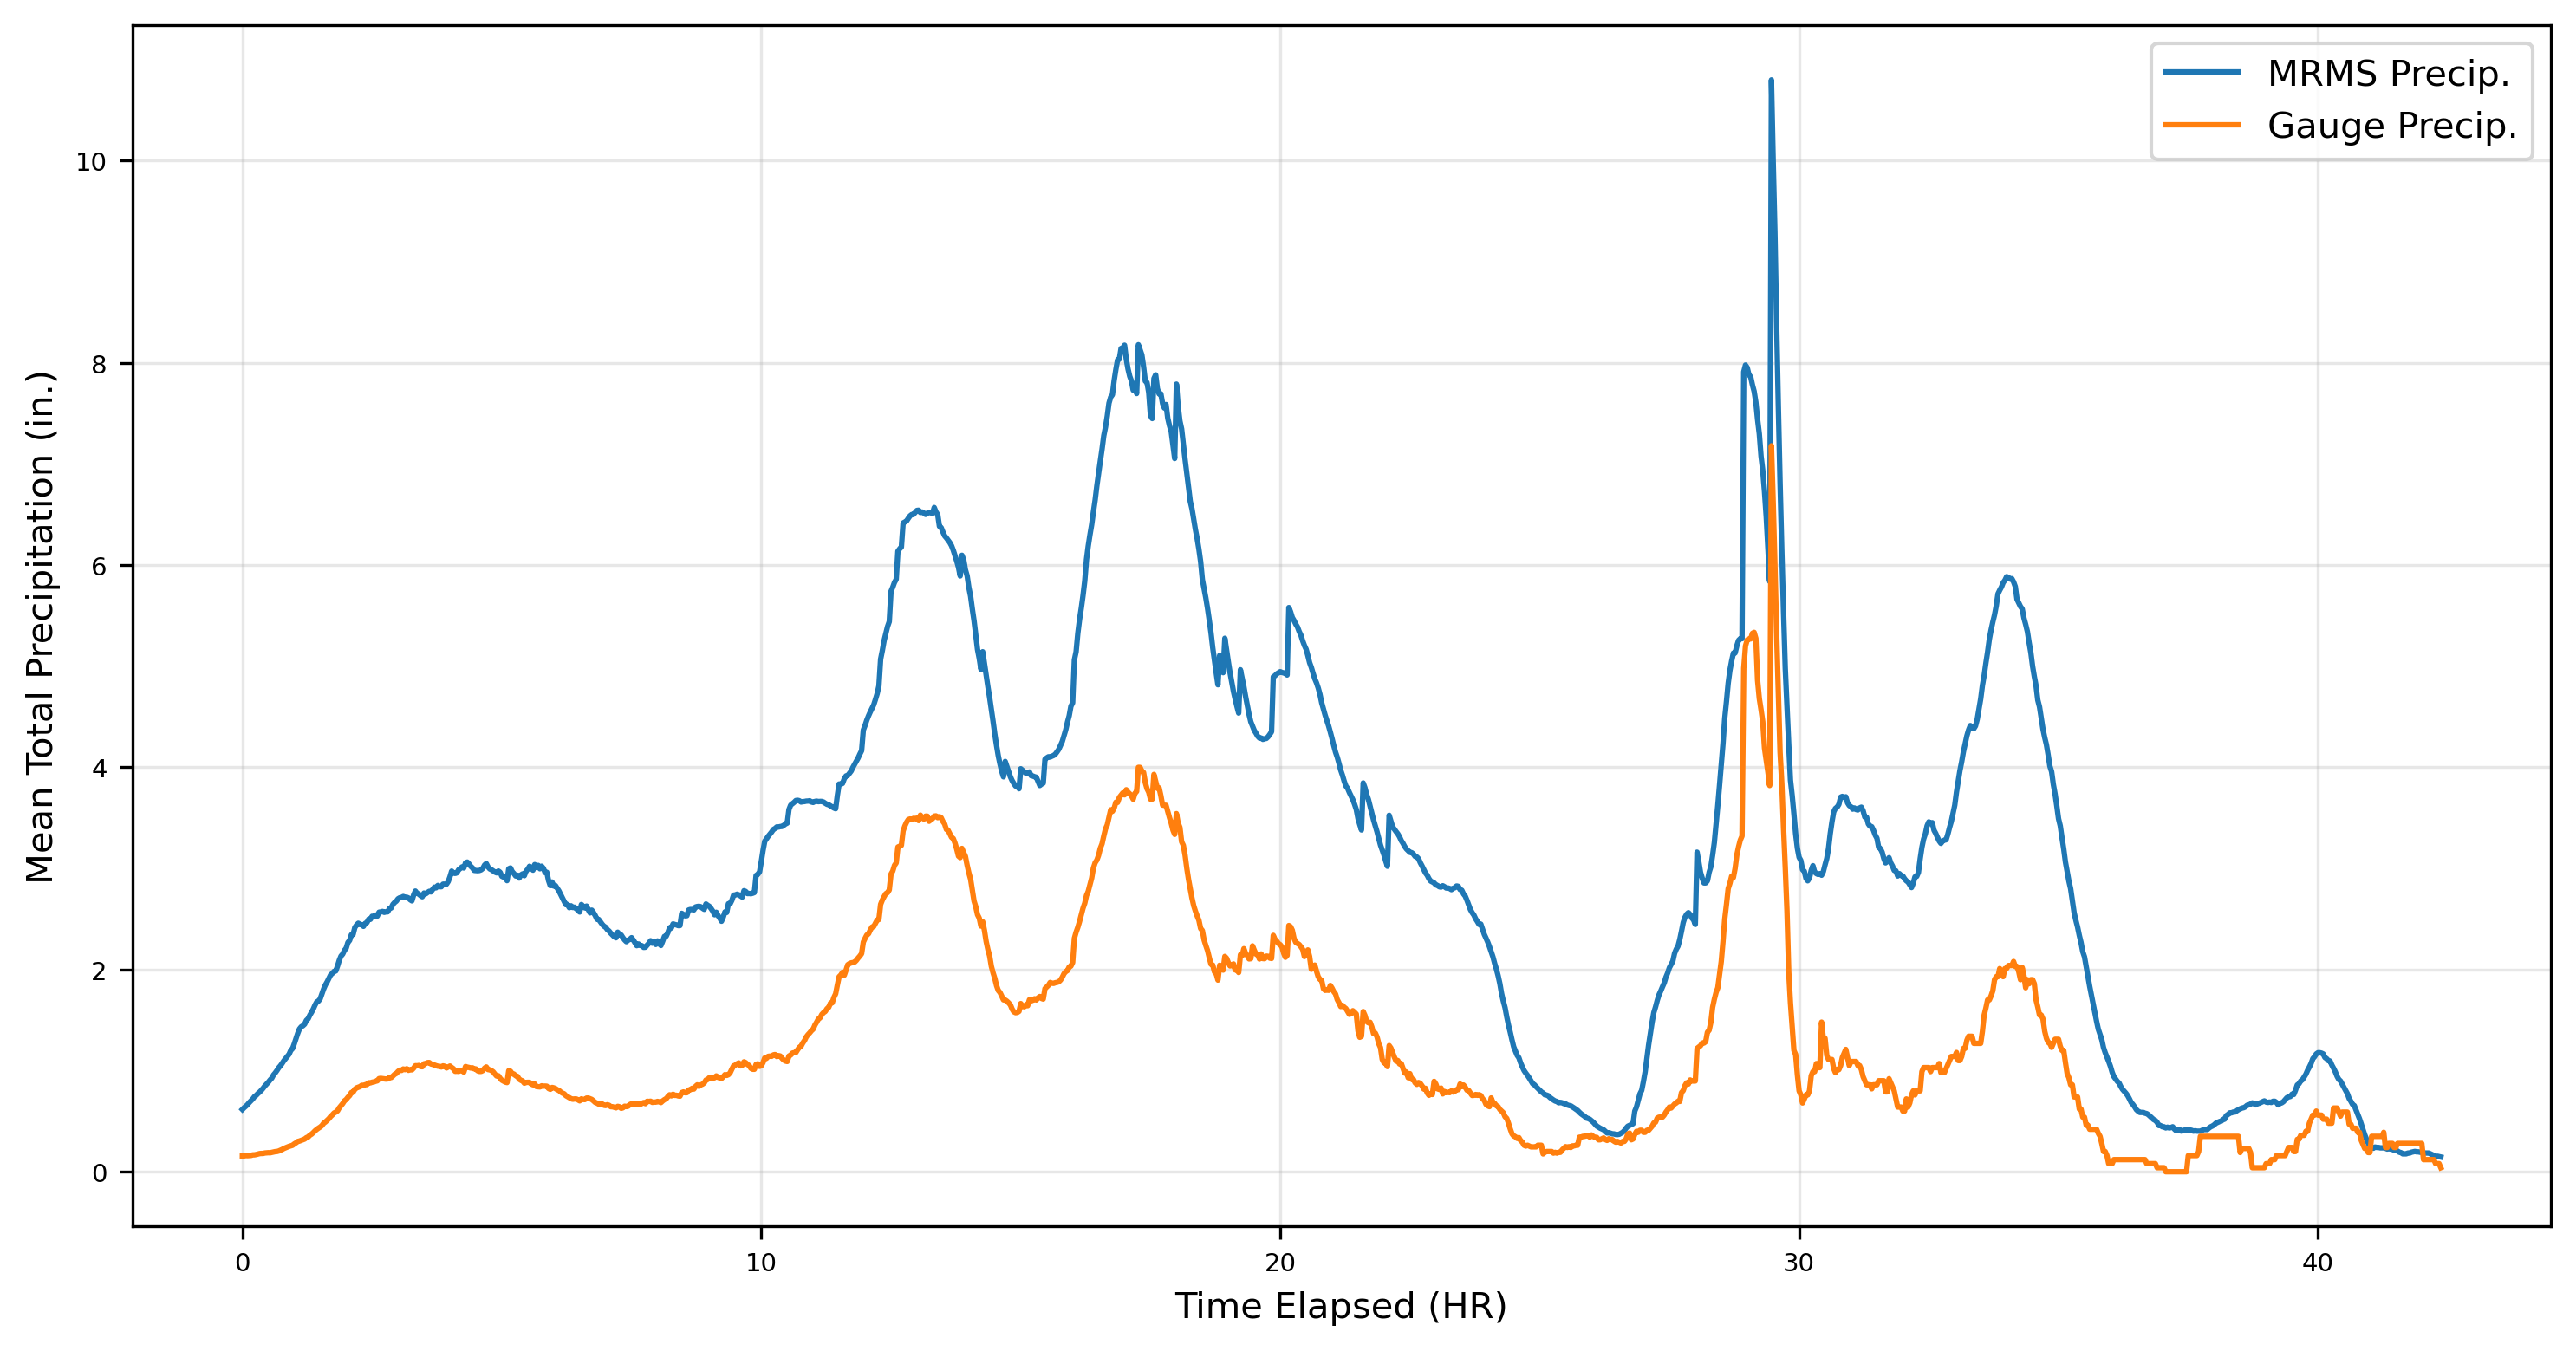

In [62]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

indices = [i/30 for i in range(len(mrms_means))]

# # plot all MRMS timeseries
# for i in range(mrms_mat.values.shape[0]):
#     arr = mrms_mat.values[i, :]
#     ax.plot(indices, arr, alpha=0.1)

ax.plot(indices, mrms_means, label="MRMS Precip.")
ax.plot(indices, gauge_means, label="Gauge Precip.")
ax.grid(alpha=0.3)

plt.xlabel("Time Elapsed (HR)")
plt.xticks(fontsize=7)
plt.ylabel("Mean Total Precipitation (in.)")
plt.yticks(fontsize=7)

plt.legend()
plt.show()

### 3. Enviornmental Analysis

In [63]:
# TODO: add enviornmental params from soundings/ASOS

import json
import sounderpy as spy


# data = spy.get_obs_data("VEF", 2021, 1, 23, 0)
test_sounding = "./data/events/2021-01-23 00:00:00/2021-01-23 00:00:00_VEF_0Z_sounding.json"

with open(test_sounding, 'r') as f:
    data = json.load(f)

In [64]:
import pandas as pd
import numpy as np
import math


# -> np.ndarray
p  = np.array(data['p']['value'])
T  = np.array(data['T']['value'])
Td = np.array(data['Td']['value'])

In [65]:
import metpy.calc as mpcalc
from metpy.units import units
from metpy.interpolate import interpolate_1d


def sounding_metrics(p_hpa: np.ndarray, t_c: np.ndarray, td_c: np.ndarray) -> dict:
    """
    Compute key sounding diagnostics:
        • 850 hPa Td
        • 700 hPa Td
        • 750 hPa T, Td, θe
        • Column precipitable water

    Parameters
    ----------
    p_hpa, t_c, td_c : 1-D array-like
        Pressure (hPa), temperature (°C) and dew-point (°C) profiles,
        ordered from surface → top.

    Returns
    -------
    dict of scalar floats
    """

    p      = p_hpa * units.hPa
    T      = t_c   * units.degC
    Td     = td_c  * units.degC

    td_850 = interpolate_1d(850 * units.hPa, p, Td).to('degC')
    td_700 = interpolate_1d(700 * units.hPa, p, Td).to('degC')
    T_750  = interpolate_1d(750 * units.hPa, p, T ).to('degC')
    Td_750 = interpolate_1d(750 * units.hPa, p, Td).to('degC')

    pwat = mpcalc.precipitable_water(p, Td).to('millimeter')
    
    theta_e_750 = mpcalc.equivalent_potential_temperature(
        750 * units.hPa,
        T_750.to('kelvin'),
        Td_750.to('kelvin')
    ).to('kelvin')

    return {
        'Td_850_C'      : td_850.m[0],
        'Td_700_C'      : td_700.m[0],
        'PWAT_mm'       : pwat.m,
        'theta_e_750_K' : theta_e_750.m[0],
    }


metrics = sounding_metrics(p, T, Td)
print(f"850 hPa dew-point : {metrics['Td_850_C']:.1f} °C")
print(f"700 hPa dew-point : {metrics['Td_700_C']:.1f} °C")
print(f"PWAT (column)     : {metrics['PWAT_mm']:.1f} mm "
      f"(~{metrics['PWAT_mm']*0.03937:.2f} in)")
print(f"750 hPa θe        : {metrics['theta_e_750_K']:.0f} K "
      f"(~{metrics['theta_e_750_K']-273.15:.1f} °C)")

850 hPa dew-point : -0.4 °C
700 hPa dew-point : -12.9 °C
PWAT (column)     : 11.8 mm (~0.46 in)
750 hPa θe        : 306 K (~32.7 °C)


In [66]:
from tqdm import tqdm
from glob import glob

# 1. load all soundings into cache
fps = glob("./data/events/*/*_sounding.json")
cache = {}
dt_objs = []

for fp in tqdm(fps):

    dts = fp.split("/")[4].strip("_sounding.json")
    year = int(dts[0:4])
    month = int(dts[5:7])
    day = int(dts[8:10])
    hour = int(dts.split("_")[-1][:-1])
    dt = datetime(year, month, day, hour)
    dt_objs.append(dt)

    with open(fp, 'r') as f:
        cache[str(dt)] = json.load(f)

100%|██████████| 463/463 [00:00<00:00, 7656.89it/s]


In [67]:
# from pprint import pprint
# from datetime import timedelta


# for dt in tqdm(df_rain_events['start_time']):
    
#     time_diffs = {}
    
#     for dt_2 in dt_objs:
        
#         # sounding - row_time
#         # -: sounding occured before row
#         # +: sounding occured after row
#         diff: timedelta = dt_2 - dt
#         time_diffs[int(diff.total_seconds())] = dt_2
    
#     time_diffs_arr = np.array(list(time_diffs.keys()))

#     # get the two smallest differences
#     sorted_diffs = sorted(time_diffs_arr[time_diffs_arr < 0.0])[-2: ]
    
#     closest_sounding_dt        = time_diffs[int(sorted_diffs[1])]
#     second_closest_sounding_dt = time_diffs[int(sorted_diffs[0])]
    
#     # ...
#     closest_sounding        = cache[str(closest_sounding_dt)]

#     p  = np.array(closest_sounding['p']['value'])
#     T  = np.array(closest_sounding['T']['value'])
#     Td = np.array(closest_sounding['Td']['value'])

#     metrics = sounding_metrics(p, T, Td)

#     eight_five_zero_dps_6z.append(float(metrics['Td_850_C']))
#     seven_zero_zero_dps_6z.append(float(metrics['Td_700_C']))
#     pwat_6z.append(float(metrics['PWAT_mm']))
#     seven_five_zero_te_6z.append(float(metrics['theta_e_750_K']))
    
#     # ...
#     second_closest_sounding = cache[str(second_closest_sounding_dt)]
    
#     p  = np.array(second_closest_sounding['p']['value'])
#     T  = np.array(second_closest_sounding['T']['value'])
#     Td = np.array(second_closest_sounding['Td']['value'])

#     metrics = sounding_metrics(p, T, Td)

#     eight_five_zero_dps_12z.append(float(metrics['Td_850_C']))
#     seven_zero_zero_dps_12z.append(float(metrics['Td_700_C']))
#     pwat_12z.append(float(metrics['PWAT_mm']))
#     seven_five_zero_te_12z.append(float(metrics['theta_e_750_K']))


In [68]:
eight_five_zero_dps_6z  = []
eight_five_zero_dps_12z = []
seven_zero_zero_dps_6z  = []
seven_zero_zero_dps_12z = []
pwat_6z                 = []
pwat_12z                = []
seven_five_zero_te_6z   = []
seven_five_zero_te_12z  = []


import numpy as np
from bisect import bisect_left 

# Sounding times in **ascending** order
sound_dts         = sorted(dt_objs)                       # list[datetime]
sound_ts          = np.fromiter((d.timestamp() for d in sound_dts),
                                dtype=np.float64)         # NumPy array
metrics_cache     = {}            # {str(dt): dict}   avoid recomputing metrics

# ---------------------------------------------------------------------------
# 1)  Main loop — O(N × log M) instead of O(N × M)
# ---------------------------------------------------------------------------
for dt in tqdm(df_rain_events['start_time']):
    ts = dt.timestamp()

    # index of the first sounding **after** the event time
    idx = np.searchsorted(sound_ts, ts, side='left')

    # Guard-rail: need two prior soundings
    if idx < 2:
        # Not enough history — skip or handle as you prefer
        continue

    # The two most recent *prior* soundings
    closest_sounding_dt        = sound_dts[idx - 1]   # Δt is smallest (most recent)
    second_closest_sounding_dt = sound_dts[idx - 2]

    # ------------------------------------------------------------------
    # 1a)  Metrics for the closest sounding (6 Z) — cached if possible
    # ------------------------------------------------------------------
    key = str(closest_sounding_dt)
    if key not in metrics_cache:
        snd               = cache[key]
        metrics_cache[key] = sounding_metrics(np.asarray(snd['p']['value']),
                                              np.asarray(snd['T']['value']),
                                              np.asarray(snd['Td']['value']))
    metrics = metrics_cache[key]

    eight_five_zero_dps_6z.append(float(metrics['Td_850_C']))
    seven_zero_zero_dps_6z.append(float(metrics['Td_700_C']))
    pwat_6z.append(float(metrics['PWAT_mm']))
    seven_five_zero_te_6z.append(float(metrics['theta_e_750_K']))

    # ------------------------------------------------------------------
    # 1b)  Metrics for the **second** closest sounding (12 Z)
    # ------------------------------------------------------------------
    key = str(second_closest_sounding_dt)
    if key not in metrics_cache:
        snd               = cache[key]
        metrics_cache[key] = sounding_metrics(np.asarray(snd['p']['value']),
                                              np.asarray(snd['T']['value']),
                                              np.asarray(snd['Td']['value']))
    metrics = metrics_cache[key]

    eight_five_zero_dps_12z.append(float(metrics['Td_850_C']))
    seven_zero_zero_dps_12z.append(float(metrics['Td_700_C']))
    pwat_12z.append(float(metrics['PWAT_mm']))
    seven_five_zero_te_12z.append(float(metrics['theta_e_750_K']))

  0%|          | 0/2210621 [00:00<?, ?it/s]

 85%|████████▍ | 1870245/2210621 [00:15<00:02, 130025.65it/s]/tmp/ipykernel_748434/564680565.py:30: UserWarning: Interpolation point out of data bounds encountered
  td_700 = interpolate_1d(700 * units.hPa, p, Td).to('degC')
/tmp/ipykernel_748434/564680565.py:31: UserWarning: Interpolation point out of data bounds encountered
  T_750  = interpolate_1d(750 * units.hPa, p, T ).to('degC')
/tmp/ipykernel_748434/564680565.py:32: UserWarning: Interpolation point out of data bounds encountered
  Td_750 = interpolate_1d(750 * units.hPa, p, Td).to('degC')
100%|██████████| 2210621/2210621 [00:19<00:00, 113966.20it/s]


In [69]:
df_rain_events["850mb_dp_s1"]      = eight_five_zero_dps_6z
df_rain_events["850mb_dp_s2"]      = eight_five_zero_dps_12z
df_rain_events["700mb_dp_s1"]      = seven_zero_zero_dps_6z
df_rain_events["700mb_dp_s2"]      = seven_zero_zero_dps_12z
df_rain_events["pwat_s1"]          = pwat_6z
df_rain_events["pwat_s2"]          = pwat_12z
df_rain_events["750mb_theta_e_s1"] = seven_five_zero_te_6z
df_rain_events["750mb_theta_e_s2"] = seven_five_zero_te_12z

df_rain_events.head()

,start_time,end_time,station_id,lat,lon,gauge_qpe,mrms_qpe,delta_qpe,event_time,event_id,850mb_dp_s1,850mb_dp_s2,700mb_dp_s1,700mb_dp_s2,pwat_s1,pwat_s2,750mb_theta_e_s1,750mb_theta_e_s2
1666,2021-01-24 02:36:00,2021-01-24 03:36:00,4914,35.850389,244.552694,0.0,0.003937,-0.003937,2021-01-24 03:36:00,1.0,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693
1667,2021-01-24 02:36:00,2021-01-24 03:36:00,4034,36.343167,244.833333,0.0,0.007874,-0.007874,2021-01-24 03:36:00,1.0,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693
1668,2021-01-24 02:36:00,2021-01-24 03:36:00,4609,35.997778,244.714444,0.0,0.003937,-0.003937,2021-01-24 03:36:00,1.0,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693
1669,2021-01-24 02:36:00,2021-01-24 03:36:00,4334,36.058000,244.677639,0.0,0.007874,-0.007874,2021-01-24 03:36:00,1.0,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693
1670,2021-01-24 02:36:00,2021-01-24 03:36:00,8,35.961000,245.372360,0.0,0.027559,-0.027559,2021-01-24 03:36:00,1.0,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693


# Motivation
> Given the enviornmental setup $\mathcal{X}$ for a heavy precipitation event, can we predict the evolution of differences between MRMS radar-only QPE and ground-truth rain gauge data?
> Can we use a data-driven approach to confidently predict: *Will MRMS overestimate QPE today? If so, by how much and at which times/locations?*

# Analysis
- Rain gauge 1H QPE and MRMS 1H QPE are timeseries values; we want to predict one from the other w/ some extra context
- Want to be able to *tweak* various envionrmental parameters and view how predicted `mrms_qpe` (i.e., rain gauge bias) changes 
- Expect for gauge-bias to be *highest* towards the start of an event, decreasing as an event progresses

## Modeling
Develop a model $f_{\theta}(\mathcal{X}_{0}, \beta, \rho, t) = \hat{y}$
- $\mathcal{X}$: enviornmental state
    - *How to represent the enviornment?*
        - Surface obs (ASOS)
        - Sounding(s)
            - Pwat
        - Time of year
        - Radar context (e.g., brightband)
- $t \in \{0, 1, ..., n\}$: timestep (event-relative)
- $\beta$: rain gauge 1H acculated precip (in.)
- $\rho$: rain gauge location (i.e., lat/lon/elevation)
- $\hat{y}$: `mrms_qpe` (target variable)

## Evaluation
- Use case-studies from a held-out test set to evaluate performance of our bias estimator

## Sanity Check 
- Predict $g_{\theta}(\beta) = \hat{y}$
- Predict $g'_{\theta}(\beta, \rho) = \hat{y}$
- Predict $g''_{\theta}(\beta, \rho, t) = \hat{y}$
- Predict $f_{\theta}(\mathcal{X}_{0}, \beta, \rho, t) = \hat{y}$
- > Ensure that we see improvements in performance with each subsequent variable we add back

## Figures
- [3d scatter plot] enviornmental vars/model inputs & `gauge_qpe` vs `delta_qpe`
    - want to normalize by magnitude of `gauge_qpe`
- [multiple timeseries overlayed 2d plot] an interactive figure
    - select env. parameters ranges (e.g., 750dp above 80F)
    - select custom date-ranges
    - x_axis: time (min. from begining of event)
    - y_axis: 1H rainfall (in.)
    - plot: MRMS 1H-QPE; each gauge is an individual timeseries; plot a mean line with higher opacity
    - plot: CCRFCD rain-gauge 1H-QPE; each gauge is an individual timeseries; plot a mean line with higher opacity

## Next Steps
- [ ] 1. plot the **correlation** (i.e., scatter plot) b/w `mrms_qpe`/`gauge_qpe` stratified by magnitudes

#### 3.1. Modeling the evolution of $\delta = \beta - y$ (rain gauge bias) throughout an event

In [ ]:
# below is our ml-friendly dataset of initial envionrmental conditions,
# rain gauge readings, MRMS readings, etc...
# we will do more post processing later to normalize each of these variables
df_rain_events_for_ml = df_rain_events.drop("event_time", axis=1)
df_rain_events_for_ml.head()

,start_time,end_time,station_id,lat,lon,gauge_qpe,mrms_qpe,delta_qpe,event_id,850mb_dp_s1,850mb_dp_s2,700mb_dp_s1,700mb_dp_s2,pwat_s1,pwat_s2,750mb_theta_e_s1,750mb_theta_e_s2
1666,2021-01-24 02:36:00,2021-01-24 03:36:00,4914,35.850389,244.552694,0.0,0.003937,-0.003937,1.0,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693
1667,2021-01-24 02:36:00,2021-01-24 03:36:00,4034,36.343167,244.833333,0.0,0.007874,-0.007874,1.0,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693
1668,2021-01-24 02:36:00,2021-01-24 03:36:00,4609,35.997778,244.714444,0.0,0.003937,-0.003937,1.0,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693
1669,2021-01-24 02:36:00,2021-01-24 03:36:00,4334,36.058000,244.677639,0.0,0.007874,-0.007874,1.0,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693
1670,2021-01-24 02:36:00,2021-01-24 03:36:00,8,35.961000,245.372360,0.0,0.027559,-0.027559,1.0,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693


In [99]:
import random


# 1. calculate a trend (best fit) line
# y = mx+b; want to minimize RMSE
def calculate_best_fit_line(x:np.ndarray, y:np.ndarray, num_iters=100):
    
    def loss(m, b):
        residuals = (((m * x) + b) - y)         # y - y_hat
        rmse = (residuals ** 2).mean() ** 0.5   # y = x
        return rmse
    
    decay = 0.75
    eps = 1.0
    m, b = 1, 0
    best_loss = loss(m, b)

    # optimize m, b
    for _ in range(num_iters):

        # (-1, 1)
        sigma = ((random.random() * 2) - 1)
        _m = m + (sigma * eps)
        _b = b + (sigma * eps)
        
        curr_loss = loss(_m, _b)
        if curr_loss < best_loss:

            best_loss = curr_loss
            m = _m
            b = _b
            eps *= decay

    return m, b, best_loss

/home/mufan/miniforge3/envs/torp/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


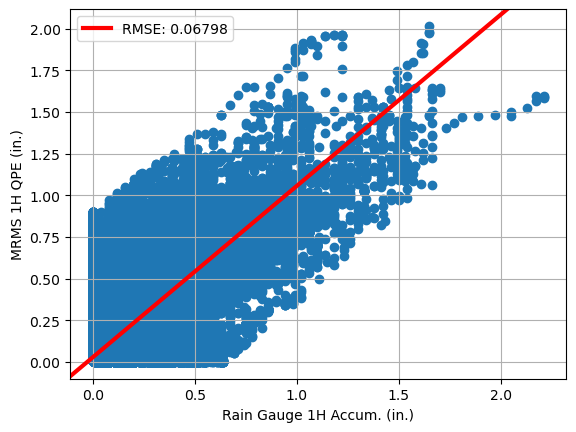

In [101]:
gauge_qpes = df_rain_events_for_ml['gauge_qpe'].to_numpy()
mrms_qpes  = df_rain_events_for_ml['mrms_qpe'].to_numpy()

m, b, best_loss = calculate_best_fit_line(gauge_qpes, mrms_qpes)
best_fit = (gauge_qpes * m) + b
point = (gauge_qpes[0], best_fit[0])

ax = plt.subplot()
ax.scatter(gauge_qpes, mrms_qpes)
ax.axline(point, slope=m, color="red", linewidth=3.0, label=f"RMSE: {best_loss:0.4}")

ax.set_xlabel("Rain Gauge 1H Accum. (in.)")
ax.set_ylabel("MRMS 1H QPE (in.)")
ax.grid()
ax.legend()

plt.show()

In [72]:
seen_ids = (
    df_rain_events_for_ml
    .groupby('event_id', sort=False)['start_time']
    .first()
    .to_dict()
)

# time elapsed since the begining of a rainfall event
delta_ts = (
    df_rain_events_for_ml['start_time']
    .sub(df_rain_events_for_ml['event_id'].map(seen_ids))
    .dt.total_seconds()
    .div(60) # -> minutes
    .tolist()
)

In [73]:
df_rain_events_for_ml['delta_t'] = delta_ts
df_rain_events_for_ml.head()

,start_time,end_time,station_id,lat,lon,gauge_qpe,mrms_qpe,delta_qpe,event_id,850mb_dp_s1,850mb_dp_s2,700mb_dp_s1,700mb_dp_s2,pwat_s1,pwat_s2,750mb_theta_e_s1,750mb_theta_e_s2,delta_t
1666,2021-01-24 02:36:00,2021-01-24 03:36:00,4914,35.850389,244.552694,0.0,0.003937,-0.003937,1.0,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693,0.0
1667,2021-01-24 02:36:00,2021-01-24 03:36:00,4034,36.343167,244.833333,0.0,0.007874,-0.007874,1.0,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693,0.0
1668,2021-01-24 02:36:00,2021-01-24 03:36:00,4609,35.997778,244.714444,0.0,0.003937,-0.003937,1.0,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693,0.0
1669,2021-01-24 02:36:00,2021-01-24 03:36:00,4334,36.058000,244.677639,0.0,0.007874,-0.007874,1.0,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693,0.0
1670,2021-01-24 02:36:00,2021-01-24 03:36:00,8,35.961000,245.372360,0.0,0.027559,-0.027559,1.0,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693,0.0


#### 4. Testing

In [74]:
test_df = df_rain_events_for_ml.copy()[
    [
        'event_id', 
        'station_id', 
        'lat', 
        'lon', 
        'delta_t', 
        'gauge_qpe', 
        'mrms_qpe',
        '850mb_dp_s1',
        '850mb_dp_s2',
        '700mb_dp_s1',
        '700mb_dp_s2',
        'pwat_s1',
        'pwat_s2',
        '750mb_theta_e_s1',
        '750mb_theta_e_s2',
    ]]

test_df.head()

,event_id,station_id,lat,lon,delta_t,gauge_qpe,mrms_qpe,850mb_dp_s1,850mb_dp_s2,700mb_dp_s1,700mb_dp_s2,pwat_s1,pwat_s2,750mb_theta_e_s1,750mb_theta_e_s2
1666,1.0,4914,35.850389,244.552694,0.0,0.0,0.003937,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693
1667,1.0,4034,36.343167,244.833333,0.0,0.0,0.007874,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693
1668,1.0,4609,35.997778,244.714444,0.0,0.0,0.003937,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693
1669,1.0,4334,36.058000,244.677639,0.0,0.0,0.007874,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693
1670,1.0,8,35.961000,245.372360,0.0,0.0,0.027559,-7.6,-0.4,-22.9,-12.9,6.461876,11.769588,298.272631,305.882693


In [75]:
# 171 train, 43 test

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error


# numerical features
# used to predict MRMS 1HR-QPE
num_cols = [
    'event_id',
    'lat', 
    'lon', 
    'delta_t', 
    'gauge_qpe',
    'mrms_qpe',
    '850mb_dp_s1',
    '850mb_dp_s2',
    '700mb_dp_s1',
    '700mb_dp_s2',
    'pwat_s1',
    'pwat_s2',
    '750mb_theta_e_s1',
    '750mb_theta_e_s2',
    ]

X = test_df[num_cols].copy()
y = test_df['mrms_qpe']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=False
)

In [76]:
# HACK: remove the remainder of an overlapping event
y_test = y_test.loc[X_test['event_id'] != 154]
X_test = X_test.loc[X_test['event_id'] != 154]

In [77]:
# remove the event_id col
X_train = X_train.drop("event_id", axis=1)
X_test  = X_test.drop("event_id", axis=1)

In [78]:
# remove y labels
X_train = X_train.drop("mrms_qpe", axis=1)
X_test  = X_test.drop("mrms_qpe", axis=1)

In [79]:
pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('rf', RandomForestRegressor(
            n_estimators=300,
            n_jobs=-1,
            random_state=42))
])

# train the model
pipe.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# evaluate on test set
y_pred = pipe.predict(X_test)

print(f'R²  : {r2_score(y_test, y_pred):.3f}')
print(f'MAE : {mean_absolute_error(y_test, y_pred):.4f}')

R²  : 0.356
MAE : 0.2594


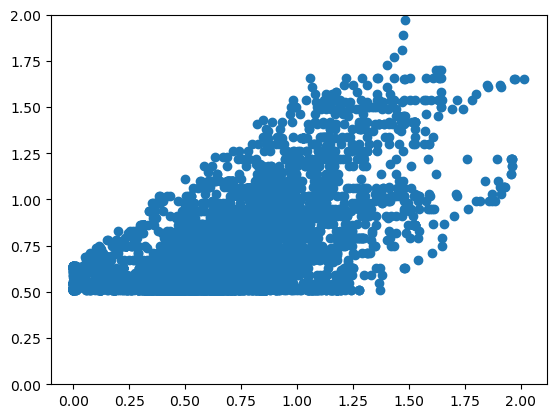

In [ ]:
plt.ylim(0, 2.0)
plt.scatter(df_rain_events_for_ml["mrms_qpe"], df_rain_events_for_ml['gauge_qpe']);

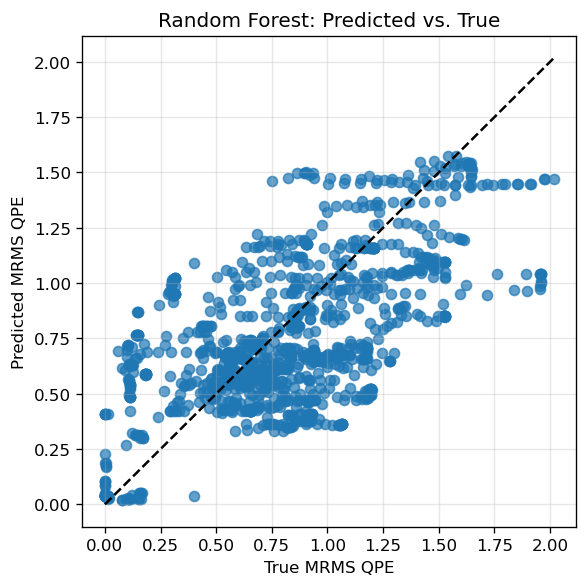

In [ ]:
plt.figure(figsize=(5,5), dpi=120)
plt.scatter(y_test, y_pred, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', lw=1.5)                 # 1-to-1 reference line
plt.xlabel('True MRMS QPE')
plt.ylabel('Predicted MRMS QPE')
plt.title('Random Forest: Predicted vs. True')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance


perm = permutation_importance(
    pipe, X_test, y_test,
    n_repeats=30, random_state=42, n_jobs=-1
)
idx = np.argsort(perm.importances_mean)[::-1]

KeyboardInterrupt: 

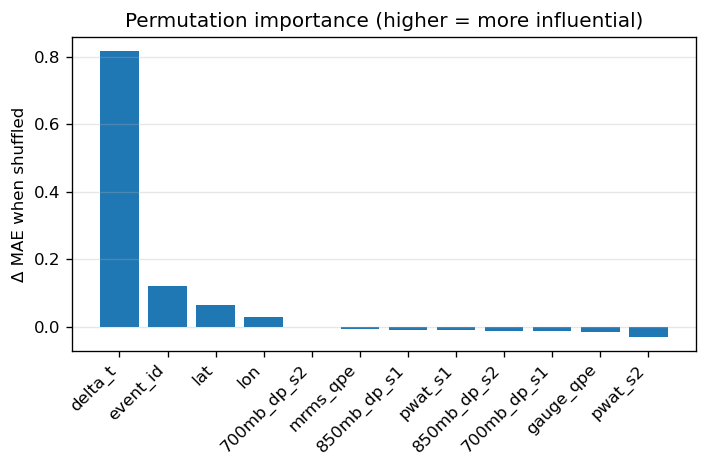

In [ ]:
plt.figure(figsize=(6, 4), dpi=120)
plt.bar(range(len(idx)), perm.importances_mean[idx])
plt.xticks(range(len(idx)), [num_cols[i] for i in idx], rotation=45, ha='right')
plt.ylabel('Δ MAE when shuffled')
plt.title('Permutation importance (higher = more influential)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()